In [1]:
##############################################################
# 1. Data Preperation
##############################################################

In [2]:
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from dotenv import load_dotenv
import os 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
def read_data():
    #df =pd.read_excel("datasets/online_retail_II.xlsx", sheet_name="Year 2010-2011")
    load_dotenv()
    DATASET_PATH = os.getenv("DATASET_PATH")
    df = pd.read_excel(DATASET_PATH)
    return df
df = read_data()

In [4]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
def prep_data(df):
    df.dropna(inplace=True)
    df = df[~df["Invoice"].str.contains("C", na=False)]
    df = df[df["Quantity"] > 0]
    replace_with_thresholds(df, "Quantity")
    replace_with_thresholds(df, "Price")
    df["TotalPrice"] = df["Price"] * df["Quantity"]
    # UK müşterilerini seçme
    df = df[df["Country"] == "United Kingdom"]
    return df

df = prep_data(df)


In [5]:
def get_analyse_date(df):
    max_date = df["InvoiceDate"].max()
    today_date = max_date + timedelta(days=2)
    #today_date = dt.datetime(2011, 12, 11)
    return today_date

# recency: means how many days have passed since customers last purches
# frequency: means how many purches a customer had until today
# monetary: means how much money spent by a customer umtil today
# T: means how many days have passed since customers first purches (Customer's Age)

def rfm_df(df):    
    today_date = get_analyse_date(df)
    rfm = df.groupby('Customer ID').agg({'InvoiceDate': [lambda date: (date.max()-date.min()).days,
                                                        lambda date: (today_date-date.min()).days],
                                        'Invoice': lambda num: num.nunique(),
                                        'TotalPrice': lambda price: price.sum()})
    rfm.columns = rfm.columns.droplevel(0)

    # sütunları isimlendirme
    rfm.columns = ['recency_cltv_p', 'tenure', 'frequency', 'monetary']

    # monetary avg hesaplama --> Gamma Gamma modeli bu şekilde istiyor
    # We need to calculate the average profit:
    rfm["monetary"] = rfm["monetary"] / rfm["frequency"]

    rfm.rename(columns={"monetary": "monetary_avg"}, inplace=True)

    # recency ve tenure değişkenlerini haftalığa çevirme
    # BG/NBD model asks us for recency and T weekly
    rfm["recency_weekly_p"] = rfm["recency_cltv_p"] / 7
    rfm["tenure_weekly_p"] = rfm["tenure"] / 7

    # kontroller
    # There are customers with "0" monetary which is weird because they got invoices but the amount is "0"
    # To calculate a life time value we better select customers which has more than one purcheses
    rfm = rfm[rfm["monetary_avg"] > 0]
    rfm = rfm[rfm["frequency"] > 1]
    rfm["frequency"] = rfm["frequency"].astype(int)
    return rfm

rfm = rfm_df(df)

In [6]:
def fit_bgf(rfm):
    # With this model we are able to calculate expected purchases of every single customer in the data set.
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(rfm['frequency'],
            rfm['recency_weekly_p'],
            rfm['tenure_weekly_p'])
    return bgf

bgf = fit_bgf(rfm)

In [7]:
def pred_bgf(bgf,rfm,week=24,n_cust=10):
    """
    'conditional_expected_number_of_purchases_up_to_time' and 'predict' are basically same.
    """

    # who is the "n_cust" customer that we expect the most to purchase in a given "week" period?
    top_customers = bgf.conditional_expected_number_of_purchases_up_to_time(week,
                                                            rfm['frequency'],
                                                            rfm['recency_weekly_p'],
                                                            rfm['tenure_weekly_p']).sort_values(ascending=False)
    print(f"top {n_cust} customer in {week} weeks: ", top_customers.head(n_cust))

    #Who are the 10 customers we expect the most to purchase in a given month?
    rfm[f"exp_sales_{int(week/4)}_month"] = bgf.predict(week,
                                            rfm['frequency'],
                                            rfm['recency_weekly_p'],
                                            rfm['tenure_weekly_p'])
    
    rfm.sort_values(f"exp_sales_{int(week/4)}_month", ascending=False).head(20)
    return rfm

rfm = pred_bgf(bgf,rfm,week=16)

top 10 customer in 16 weeks:  Customer ID
17850.00000   37.50662
12748.00000   35.45495
15311.00000   29.70236
13089.00000   26.77198
14606.00000   25.19560
13694.00000   23.03113
17841.00000   22.51324
18102.00000   21.98215
15061.00000   21.23442
17949.00000   18.31872
dtype: float64


In [8]:
rfm.head()

,recency_cltv_p,tenure,frequency,monetary_avg,recency_weekly_p,tenure_weekly_p,exp_sales_4_month
Customer ID,,,,,,,
12346.00000,196,362,11,33.89636,28.00000,51.71429,0.50429
12745.00000,87,211,2,361.92500,12.42857,30.14286,1.13676
12747.00000,363,369,16,317.53313,51.85714,52.71429,4.41692
12748.00000,369,372,144,141.18451,52.71429,53.14286,35.45495
12749.00000,121,158,4,701.62000,17.28571,22.57143,2.64763


In [9]:
def expected_transaction(bgf,rfm,week=24):
    # 6 Ayda Tüm Şirketin Beklenen Satış Sayısı Nedir?  952.4548865072431
    trasaction_count = bgf.predict(week,
                rfm['frequency'],
                rfm['recency_weekly_p'],
                rfm['tenure_weekly_p']).sum()
    print(f"Number of transaction in {week} week is: {trasaction_count}")
    
expected_transaction(bgf,rfm,week=24)

Number of transaction in 24 week is: 9493.576111222057


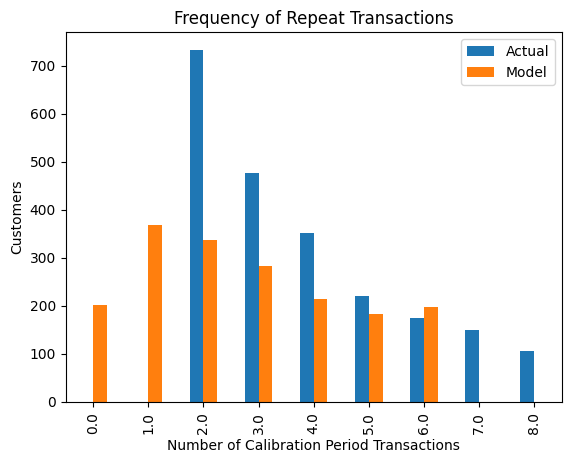

In [10]:
def eval_predictions(bgf):
    # Tahmin Sonuçlarının Değerlendirilmesi
    plot_period_transactions(bgf)
    plt.show()
    
eval_predictions(bgf)

In [11]:
def fit_ggf(rfm):
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(rfm['frequency'], rfm['monetary_avg'])
    return ggf

ggf = fit_ggf(rfm)

In [12]:
def pred_ggf(ggf,rfm):
    #Gamma-Gamma model to calculate the expected average profit per customer
    rfm["expected_average_profit"] = ggf.conditional_expected_average_profit(rfm['frequency'],
                                                                            rfm['monetary_avg'])
    return rfm
rfm = pred_ggf(ggf,rfm)

In [13]:
print(rfm.sort_values("expected_average_profit", ascending=False).head(2))

             recency_cltv_p  tenure  frequency  monetary_avg  \
Customer ID                                                    
17450.00000              70      75          7    5321.58500   
14091.00000              44     335          2    4584.04500   

             recency_weekly_p  tenure_weekly_p  exp_sales_4_month  \
Customer ID                                                         
17450.00000          10.00000         10.71429            6.20647   
14091.00000           6.28571         47.85714            0.15663   

             expected_average_profit  
Customer ID                           
17450.00000               5455.99080  
14091.00000               5016.74386  


In [14]:
def calculate_clv(bgf,ggf,rfm,month):
    #By combining bgf(BGNBD Model) and ggf(Gamma-Gamma Model) it can be calculated CLTV for different time periods
    cltv = ggf.customer_lifetime_value(bgf,
                                    rfm['frequency'],
                                    rfm['recency_weekly_p'],
                                    rfm['tenure_weekly_p'],
                                    rfm['monetary_avg'],
                                    time=month,
                                    freq="W",
                                    discount_rate=0.01)

    cltv = cltv.reset_index()
    rfm_cltv = rfm.merge(cltv, on="Customer ID", how="left")
    rfm_cltv.sort_values(by="clv", ascending=False).head()
    return rfm_cltv

rfm_cltv = calculate_clv(bgf,ggf,rfm,month=6)

In [15]:
print(rfm_cltv.head())

   Customer ID  recency_cltv_p  tenure  frequency  monetary_avg  \
0  12346.00000             196     362         11      33.89636   
1  12745.00000              87     211          2     361.92500   
2  12747.00000             363     369         16     317.53313   
3  12748.00000             369     372        144     141.18451   
4  12749.00000             121     158          4     701.62000   

   recency_weekly_p  tenure_weekly_p  exp_sales_4_month  \
0          28.00000         51.71429            0.50429   
1          12.42857         30.14286            1.13676   
2          51.85714         52.71429            4.41692   
3          52.71429         53.14286           35.45495   
4          17.28571         22.57143            2.64763   

   expected_average_profit        clv  
0                 34.78005   27.35291  
1                397.97563  702.69366  
2                321.21546 2212.98873  
3                141.37916 7819.88813  
4                734.07709 3013.36049  


In [16]:
print(rfm_cltv.shape)

(2665, 10)


In [17]:
#Now in order "clv" score we calculated to make sense to us lets make it scaleable
def scale_clv(df):
    scaler = MinMaxScaler(feature_range=(1, 100))
    scaler.fit(df[["clv"]])
    df["scaled_clv"] = scaler.transform(df[["clv"]])
    return df

rfm_cltv = scale_clv(rfm_cltv)

In [18]:
rfm_cltv.head(4)

,Customer ID,recency_cltv_p,tenure,frequency,monetary_avg,recency_weekly_p,tenure_weekly_p,exp_sales_4_month,expected_average_profit,clv,scaled_clv
0,12346.00000,196,362,11,33.89636,28.00000,51.71429,0.50429,34.78005,27.35291,1.02235
1,12745.00000,87,211,2,361.92500,12.42857,30.14286,1.13676,397.97563,702.69366,1.57411
2,12747.00000,363,369,16,317.53313,51.85714,52.71429,4.41692,321.21546,2212.98873,2.80804
3,12748.00000,369,372,144,141.18451,52.71429,53.14286,35.45495,141.37916,7819.88813,7.38896


In [19]:
def segment_by_clv(df):
    df["clv_segment"] = pd.qcut(df["scaled_clv"], 4, labels=["bronze","silver", "gold", "premium"])
    return df

rfm_cltv = segment_by_clv(rfm_cltv)

In [20]:
rfm_cltv.tail(500)

,Customer ID,recency_cltv_p,tenure,frequency,monetary_avg,recency_weekly_p,tenure_weekly_p,exp_sales_4_month,expected_average_profit,clv,scaled_clv,clv_segment
2165,17243.00000,368,375,44,277.56841,52.57143,53.57143,11.09592,278.74164,4825.10954,4.94219,premium
2166,17244.00000,350,370,4,217.78500,50.00000,52.85714,1.47442,228.53473,525.45115,1.42930,silver
2167,17246.00000,191,375,2,19.46000,27.28571,53.57143,0.76484,23.33766,27.83246,1.02274,bronze
2168,17251.00000,342,361,2,264.57500,48.85714,51.57143,1.00910,291.48005,458.52531,1.37462,bronze
2169,17255.00000,55,83,2,250.36000,7.85714,11.85714,2.55679,275.92962,1088.78103,1.88955,gold
...,...,...,...,...,...,...,...,...,...,...,...,...
2660,18276.00000,336,366,5,264.13200,48.00000,52.28571,1.72255,274.30401,736.81257,1.60199,silver
2661,18277.00000,97,131,4,256.66500,13.85714,18.71429,2.96627,269.15909,1236.23901,2.01003,gold
2662,18283.00000,275,295,6,106.96167,39.28571,42.14286,2.33723,110.75666,403.13071,1.32936,bronze
2663,18286.00000,247,360,2,641.68500,35.28571,51.42857,0.93360,704.01776,1024.60481,1.83712,gold


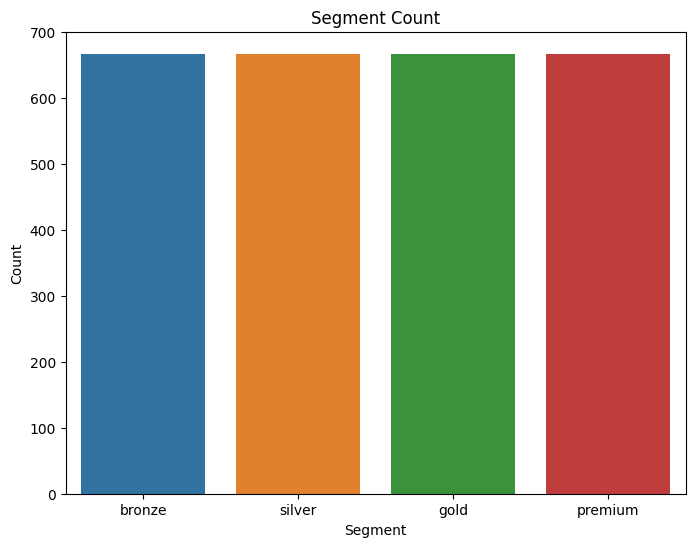

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_segment_counts(df,column):
    # Segment değerlerinin sayısını hesaplayalım
    segment_counts = df[column].value_counts()

    # Görselleştirme
    plt.figure(figsize=(8, 6))
    sns.barplot(x=segment_counts.index, y=segment_counts.values)
    plt.title('Segment Count')
    plt.xlabel('Segment')
    plt.ylabel('Count')
    plt.show()

plot_segment_counts(df=rfm_cltv,column="clv_segment")

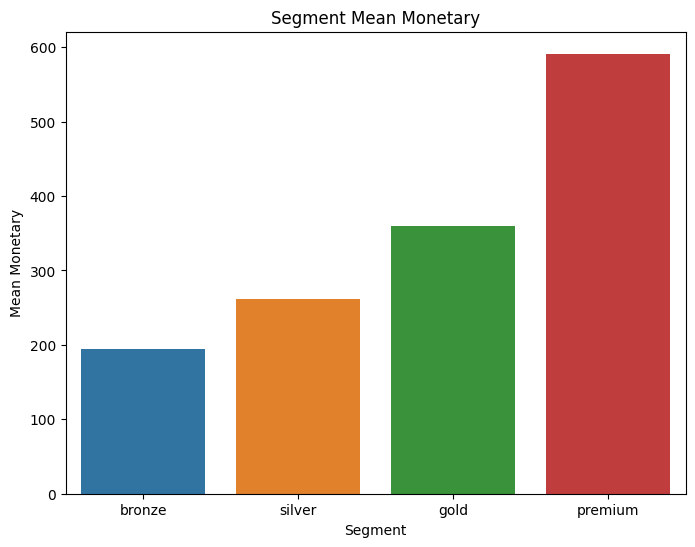

In [22]:
def plot_segment_avg_monetary(df,column):
    # Segmentlere göre ortalama monetary değerleri hesaplayalım
    segment_means = df.groupby(column)['monetary_avg'].mean().reset_index()

    # Görselleştirme
    plt.figure(figsize=(8, 6))
    sns.barplot(x=column, y='monetary_avg', data=segment_means)
    plt.title('Segment Mean Monetary')
    plt.xlabel('Segment')
    plt.ylabel('Mean Monetary')
    plt.show()

plot_segment_avg_monetary(df=rfm_cltv,column="clv_segment")

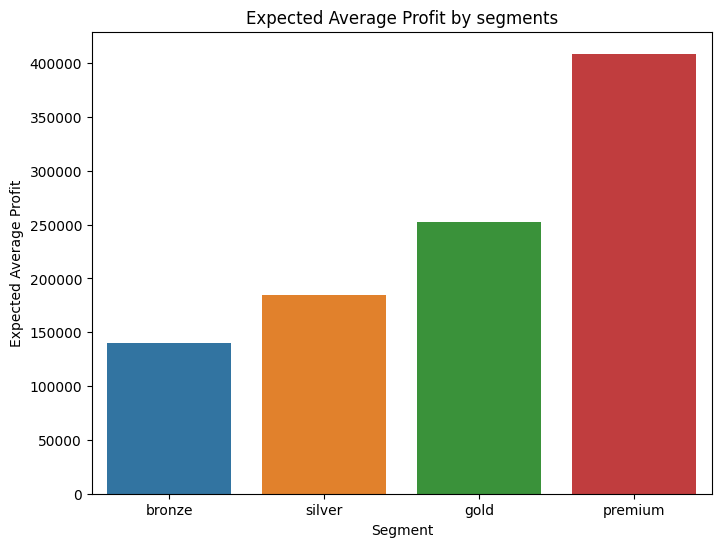

In [23]:
def plot_segment_exp_profit(df,column):
    # Segmentlere göre ortalama monetary değerleri hesaplayalım
    segment_means = df.groupby(column)['expected_average_profit'].sum().reset_index()

    # Görselleştirme
    plt.figure(figsize=(8, 6))
    sns.barplot(x=column, y='expected_average_profit', data=segment_means)
    plt.title('Expected Average Profit by segments')
    plt.xlabel('Segment')
    plt.ylabel('Expected Average Profit')
    plt.show()

plot_segment_exp_profit(df=rfm_cltv,column="clv_segment")